In [1]:
#| default_exp app_v3

#### Competition

[LINK](https://www.kaggle.com/competitions/playground-series-s3e11/overview)

#### Imports

In [1]:
#| export


from fastai.tabular.all import *

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


import xgboost as xgb

import seaborn as sns

import optuna

import json

In [8]:
Path('./training_params').mkdir(parents=True, exist_ok=True)
Path('./predictions').mkdir(parents=True, exist_ok=True)

#### Downloading Datasets

In [3]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
#| export
comp = 'playground-series-s3e11'
path = setup_comp(comp, install='fastai')

In [5]:
# copy .gitignore template from my home directory and append project data folder to it
if not os.path.exists('.gitignore'):
    !cp ~/.gitignore .
if comp not in open('.gitignore').read():
    with open('.gitignore', 'a') as f: f.write(f'{comp}')

#### Create Dataframes

In [6]:
#| export
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_comb = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
#| export
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)
df_comb.drop(['id'], axis=1, inplace=True)

In [8]:
#| export
df_train['store_sales_per_children'] = df_train['store_sales(in millions)'] / df_train['total_children']

In [9]:
#| export
for column in df_train.columns:
    if (list(df_train[column].unique()) == [0.0, 1.0]):
        df_train.loc[:, column] = df_train[column].astype('bool')

In [10]:
#| export
train_idxs = np.arange(len(df_train))
test_idxs = np.arange(len(df_train), len(df_comb))

In [11]:
dep_var = 'cost'
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(df_comb, max_card=1, dep_var=dep_var)
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))

In [12]:
df_train = df_comb.iloc[train_idxs]
df_test = df_comb.iloc[test_idxs]

In [13]:
#| export
to_final = TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)
test_final = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)
dls_final = to_final.dataloaders(bs=1024)

#### Optimizing NN Parameters with Optuna

In [14]:
def nn_trial(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1)
    wd = trial.suggest_float('wd', 1e-6, 1e-1)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_dim = trial.suggest_int('hidden_dim', 100, 1000)
    

    layer_sizes = [hidden_dim] * n_layers

    learn = tabular_learner(dls_final, layers=layer_sizes, metrics=rmse, wd=wd)
    learn.fit_one_cycle(10, lr)

    # Return the validation loss (or any other metric of your choice)
    return learn.recorder.values[-1][0]


In [15]:
nn_study = False

In [16]:
if nn_study == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(nn_trial, n_trials=50)
    with open('./training_params/nn_params.json', 'w') as fp:
        json.dump(study.best_params, fp)

In [12]:
with open('./training_params/nn_params.json', 'r') as fp:
    nn_best_params = json.load(fp)

In [18]:
nn_lr = nn_best_params['lr']
nn_best_params.pop('lr')

0.028868944455163

In [19]:
nn_best_params['layers'] = [nn_best_params['hidden_dim']] * nn_best_params['n_layers']
nn_best_params.pop('n_layers')
nn_best_params.pop('hidden_dim')

722

In [20]:
nn_best_params

{'wd': 0.005015308901580747, 'layers': [722, 722, 722]}

### Neural Network Model

#### Train Model

In [23]:
#| export
nn_train = False
epochs = 17

In [24]:
#| export
if nn_train == True:
    learn_final = tabular_learner(dls_final, **nn_best_params, y_range=(0, 150), metrics=rmse)
    learn_final.fit_one_cycle(epochs, nn_lr)
    learn_final.export('models/tab_learner.pkl')


epoch,train_loss,valid_loss,_rmse,time
0,892.058472,889.543152,29.825209,00:02
1,885.733948,866.067871,29.429033,00:02
2,850.472168,858.476868,29.299772,00:02
3,838.717102,855.936340,29.256392,00:02
4,837.272766,828.506165,28.783783,00:02
5,832.202698,829.981018,28.809391,00:02
6,821.280701,819.152283,28.620838,00:02
7,822.203247,819.472778,28.626431,00:02
8,813.449463,824.132446,28.707708,00:02
9,807.433716,801.534058,28.311377,00:02


In [25]:
learn_final = load_learner('models/tab_learner.pkl')

#### Get NN Model Predictions

In [26]:
#| export
test_dl = learn_final.dls.test_dl(df_test)
nn_preds, _ = learn_final.get_preds(dl=test_dl)

In [27]:
nn_preds = nn_preds.squeeze().numpy()
np.savetxt('./predictions/nn_preds.csv', nn_preds, delimiter=',')

In [17]:
nn_preds = np.loadtxt('./predictions/nn_preds.csv', delimiter=',')

In [19]:
nn_preds.shape

(240224,)

### Random Forest Model

In [29]:
#| export
xs, y = to_final.train.xs, to_final.train.y
valid_xs, valid_y = to_final.valid.xs, to_final.valid.y
test_xs = test_final.train.xs

In [30]:
#| export
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, 
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

#### RF Optuna Optimization

In [31]:
rf_study = False

In [32]:
def rf_param(trial, xs, y):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_samples = trial.suggest_int('max_samples', 100, 200_000)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    model = rf(xs, y, n_estimators=n_estimators, max_samples=max_samples, 
               max_features=max_features, min_samples_leaf=min_samples_leaf)
    
    score = cross_val_score(model, xs, y, cv=5, scoring='neg_mean_squared_error')
    return math.sqrt(-1 * score.mean())

In [33]:
if rf_study == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: rf_param(trial, xs, y), n_trials=50)
    with open('./training_params/rf_params.json', 'w') as fp:
        json.dump(study.best_params, fp) 

In [13]:
with open('./training_params/rf_params.json', 'r') as fp:
    rf_best_params = json.load(fp)

In [35]:
#| export
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

In [36]:
#| export
def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [37]:
#| export
m = rf(xs, y, **rf_best_params)

In [38]:
rf_mse = m_rmse(m, valid_xs, valid_y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(26.499917, 28.114526)

In [39]:
#| export
rf_preds = m.predict(test_xs)
np.savetxt('./predictions/rf_preds.csv', rf_preds, delimiter=',')

In [21]:
rf_preds = np.loadtxt('./predictions/rf_preds.csv', delimiter=',')

#### RF Feature Importance

In [40]:
#| export
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False) 

In [41]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
9,store_sqft,0.181537
0,store_sales(in millions),0.162741
5,gross_weight,0.149150
2,total_children,0.108468
8,units_per_case,0.106188
4,avg_cars_at home(approx).1,0.086597
3,num_children_at_home,0.070824
14,florist,0.038458
1,unit_sales(in millions),0.021880
6,recyclable_package,0.020138


***

### Gradient Boosting

##### Feature Importance

In [42]:
#| export
train_fi = df_train.drop(columns = ['cost'])
target_fi = df_train['cost']

In [43]:
#| export
def plot_fi(data,ax = None, title = None):
    fi = pd.Series(data, index = train_fi.columns).sort_values(ascending = True)
    fi.plot(kind = 'barh', ax = ax)

In [44]:
#| export
x_train, x_test, y_train, y_test = train_test_split(train_fi, target_fi, test_size=0.2)

In [45]:
#| export
fi_params = {'learning_rate': 0.2456172216493356,
 'max_depth': 10,
 'lambda': 0.0023120639864473262,
 'alpha': 0.5848465230832824,
 'colsample_bytree': 0.9966638720347625,
 'min_child_weight': 0,
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [46]:
#| export
model = xgb.XGBRegressor(**fi_params)


In [47]:
#| export
model.fit(x_train, y_train)

XGBRegressor(alpha=0.5848465230832824, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9966638720347625, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.0023120639864473262,
             learning_rate=0.2456172216493356, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

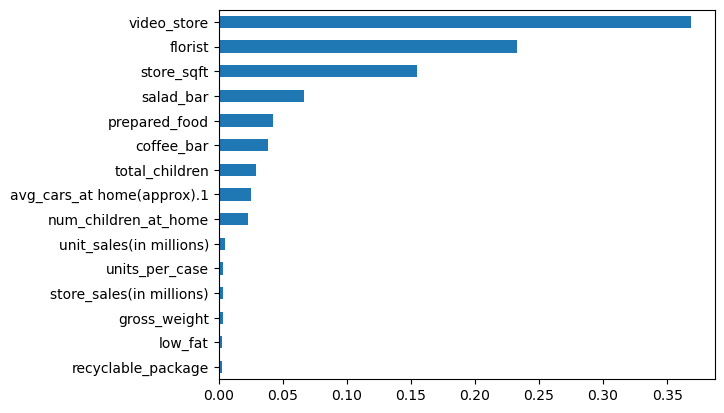

In [48]:
plot_fi(model.feature_importances_)

In [49]:
#| export
r = permutation_importance(model, x_test, y_test, n_repeats=1, random_state=46)

In [50]:
#| export
fi = pd.Series(r['importances'].reshape(15,), index = train_fi.columns).sort_values(ascending = True)

<AxesSubplot: >

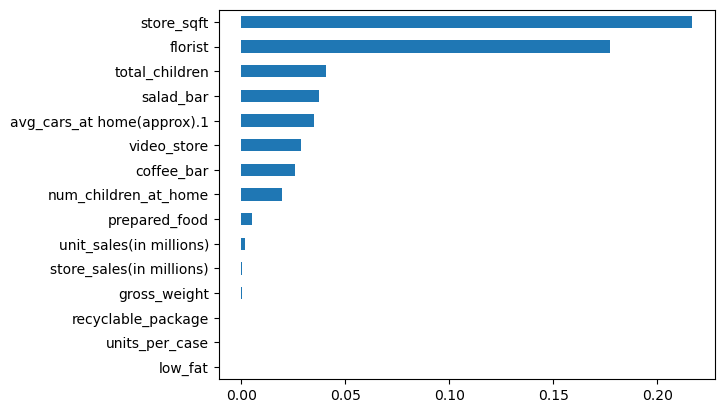

In [51]:
fi.plot(kind = 'barh')

In [52]:
#| export
features = list(fi.index)
cols_to_drop = features[0:6]

In [53]:
#| export
df_train = df_train.drop(columns=cols_to_drop)

In [54]:
#| export
df_test = df_test.drop(columns=cols_to_drop)

In [55]:
#| export
def fe(data):
    data = data.replace([np.inf, -np.inf], 10)
    return data

In [56]:
#| export
train_fe = fe(df_train)
test_fe = fe(df_test)

In [57]:
#| export
train = train_fe.drop(columns=['cost'])

In [58]:
#| export
target = train_fe['cost']

#### Finding the Best Parameters With Optuna

In [59]:
#| export
x_train, x_test, y_train, y_test = train_test_split(train,target, test_size = 0.2)
d_train = xgb.DMatrix(x_train,y_train)
d_test = xgb.DMatrix(x_test,y_test)


In [60]:
#| export
glob_params = {
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle'
}

In [61]:
#| export
def objective(trial):
    params = {
        'verbosity':0,
        'learning_rate': trial.suggest_float('learning_rate',1e-10,1.0),
        'max_depth':trial.suggest_int('max_depth', 3, 12),
#        'gamma':trial.suggest_float('gamma',0,8),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree',1e-5,1.0),
        'min_child_weight':trial.suggest_int('min_child_weight',0,1),
        'booster':trial.suggest_categorical("booster", ["dart", "gbtree",'gblinear']),
        'sampling_method': trial.suggest_categorical('sampling_method',['uniform','gradient_based']),
        'grow_policy': trial.suggest_categorical('grow_policy',['depthwise','lossguide']),
#         'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
#         'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),    
    }
    num_boost_round = params.pop('num_boost_round')
    params.update(glob_params)
    sch_prm = xgb.train(params, d_train, num_boost_round=200,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score


In [62]:
#| export
run_study = False

In [63]:
#| export
if run_study == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials = 100,)
    # save study.best_params a json file to load later
    with open('./training_params/xgb_params.json', 'w') as fp:
        json.dump(study.best_params, fp)

#### Assigning Best Parameters

In [25]:
#| export
with open('./training_params/xgb_params.json', 'r') as fp:
    study_best_params = json.load(fp)

In [26]:
study_best_params

{'learning_rate': 0.9966089304842916,
 'max_depth': 12,
 'lambda': 0.36999767740684797,
 'alpha': 0.00034306004800048104,
 'colsample_bytree': 0.9657745153267124,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise'}

In [65]:
#| export
best_params = {
 'learning_rate': 0.9319687783879956,
 'max_depth': 12,
 'lambda': 0.02022953533538882,
 'alpha': 9.277352577569814e-07,
 'colsample_bytree': 0.7477567097593131,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [66]:
#| export
best_params.update(study_best_params)

In [67]:
def max_boost_round(trial):
    params = {
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1500),
    }
    num_boost_round = params.pop('num_boost_round')
    params.update(glob_params)
    sch_prm = xgb.train(params, d_train, num_boost_round=num_boost_round,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score

In [68]:
run_max_boost = False

In [69]:
#| export
if run_max_boost == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(max_boost_round, n_trials = 20,)
    # save study.best_params a json file to load later
    with open('./training_params/boost_params.json', 'w') as fp:
        json.dump(study.best_params, fp)

In [10]:
#| export
with open('./training_params/boost_params.json', 'r') as fp:
    boost_best_params = json.load(fp)

In [71]:
num_boost_round = boost_best_params['num_boost_round']

In [72]:
num_boost_round

1496

In [73]:
best_params

{'learning_rate': 0.9966089304842916,
 'max_depth': 12,
 'lambda': 0.36999767740684797,
 'alpha': 0.00034306004800048104,
 'colsample_bytree': 0.9657745153267124,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

***

#### Creating GB Model

In [74]:
#| export
cont, cat = cont_cat_split(df_train, max_card=1, dep_var='cost')

In [75]:
to = TabularPandas(df_train, procs, cat, cont, y_names='cost', splits=splits)

In [76]:
to_test = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)

In [77]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
test_xs = to_test.xs

In [78]:
gb_train = xgb.DMatrix(xs, label=y)
gb_valid = xgb.DMatrix(valid_xs, label=valid_y)
gb_test = xgb.DMatrix(test_xs)

In [79]:
# use best params in xgb.train
model =  xgb.train(best_params, gb_train, num_boost_round = num_boost_round,
                        evals = [(gb_valid, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=True
                       )

[0]	valid-rmsle:3.58253
[1]	valid-rmsle:3.00947
[2]	valid-rmsle:2.45537
[3]	valid-rmsle:1.92667
[4]	valid-rmsle:1.43335
[5]	valid-rmsle:0.99191
[6]	valid-rmsle:0.63145
[7]	valid-rmsle:0.40050
[8]	valid-rmsle:0.31904
[9]	valid-rmsle:0.30658
[10]	valid-rmsle:0.30358
[11]	valid-rmsle:0.30166
[12]	valid-rmsle:0.30111
[13]	valid-rmsle:0.30007
[14]	valid-rmsle:0.29959
[15]	valid-rmsle:0.29890
[16]	valid-rmsle:0.29857
[17]	valid-rmsle:0.29829
[18]	valid-rmsle:0.29803
[19]	valid-rmsle:0.29769
[20]	valid-rmsle:0.29738
[21]	valid-rmsle:0.29701
[22]	valid-rmsle:0.29666
[23]	valid-rmsle:0.29642
[24]	valid-rmsle:0.29631
[25]	valid-rmsle:0.29611
[26]	valid-rmsle:0.29600
[27]	valid-rmsle:0.29581
[28]	valid-rmsle:0.29569
[29]	valid-rmsle:0.29554
[30]	valid-rmsle:0.29544
[31]	valid-rmsle:0.29537
[32]	valid-rmsle:0.29523
[33]	valid-rmsle:0.29512
[34]	valid-rmsle:0.29506
[35]	valid-rmsle:0.29496
[36]	valid-rmsle:0.29491
[37]	valid-rmsle:0.29483
[38]	valid-rmsle:0.29474
[39]	valid-rmsle:0.29471
[40]	valid

#### Getting GB Predictions

In [80]:
xgb_preds = model.predict(xgb.DMatrix(test_xs))

In [81]:
np.savetxt('./predictions/xgb_preds.csv', xgb_preds, delimiter=',')

In [23]:
xgb_preds = np.loadtxt('./predictions/xgb_preds.csv', delimiter=',')

In [24]:
xgb_preds

array([ 90.8746109 ,  94.17379761,  94.01966095, ...,  94.01966095,
       105.49355316, 110.67835999])

***

#### XGB K-Folds Cross Validation

In [84]:
k_folds_train = False

In [85]:
if k_folds_train == True:
    # set the number of folds
    num_folds = 10
    # create empty list to store the loglosses
    loglosses = []
    # create empty array to store the predictions
    k_gb_preds = np.zeros(len(to_test))
    # create a kfold object
    kf = KFold(n_splits=num_folds, shuffle = True, random_state = 1042)
    # loop through each fold
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X=xs, y=y)):
        # print the fold number
        print('-'*20, 'Fold:', fold + 1, '-'*20)
        # split the data into train and validation
        X_train, X_test = train.iloc[trn_idx], train.iloc[val_idx]
        # split the target into train and validation
        y_train, y_test = target.iloc[trn_idx], target.iloc[val_idx]
        
        # create the train and validation data
        d_train = xgb.DMatrix(X_train,y_train)
        d_test = xgb.DMatrix(X_test,y_test)
        
        # train the model
        k_gb_model =  xgb.train(best_params, d_train, num_boost_round = num_boost_round,
                            evals = [(d_test, 'valid')], 
                            early_stopping_rounds=20, verbose_eval=True
                        )
    #     preds = model.predict(d_test)
    #     logloss = metrics.log_loss(y_test, preds)
    #     loglosses.append(logloss)
    #     print(f'Logloss: {logloss}')
        # predict on the test set
        preds = k_gb_model.predict(xgb.DMatrix(test_xs))
        # add the predictions to the final predictions array
        k_gb_preds += preds / num_folds

    # save k_gb_preds to csv
    np.savetxt('./predictions/k_gb_preds.csv', k_gb_preds, delimiter=',')

In [15]:
if 'k_gb_preds' not in locals():
    k_gb_preds = np.loadtxt('./predictions/k_gb_preds.csv', delimiter=',')

***

In [87]:
xgb_mse = r_mse(model.predict(gb_valid), valid_y)
xgb_mse

28.092324

#### Ensemble of All Predictions

In [88]:
rf_preds, nn_preds, k_gb_preds, xgb_preds

(array([100.29254594,  90.11321236,  93.88414254, ...,  96.77864943,
        113.79314718, 108.92474409]),
 array([ 97.58751,  98.36828,  98.02765, ...,  98.26348, 110.39424,
        116.08539], dtype=float32),
 array([103.21230888,  73.93023109,  99.01429653, ...,  99.01429653,
         77.44030571, 104.49899864]),
 array([ 90.8746109 ,  94.17379761,  94.01966095, ...,  94.01966095,
        105.49355316, 110.67835999]))

In [89]:
#| export
ens_preds = (nn_preds + rf_preds + k_gb_preds + xgb_preds) / 4

In [90]:
ens_preds

array([ 97.99174372,  89.14637989,  96.23643724, ...,  97.01902201,
       101.78031185, 110.04687273])

In [91]:
#| export
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df['cost'] = ens_preds
sample_df.to_csv('submission.csv', index=False)

In [92]:
!head submission.csv

id,cost
360336,97.99174372098629
360337,89.1463798919223
360338,96.23643723632468
360339,94.19042454748141
360340,81.41819545600084
360341,99.18837650376445
360342,99.43824432657357
360343,88.6890326355393
360344,88.93474951696624


In [93]:
new_sub_nums = sample_df['cost'].to_numpy()

In [94]:
benchmark_df = pd.read_csv('benchmark_submission.csv')

In [95]:
benchmark_nums = benchmark_df['cost'].to_numpy()

In [96]:
# find the average difference between the new and old submission numbers
diffs = np.mean(np.abs(new_sub_nums - benchmark_nums))
diffs


2.134206350495986

In [97]:
submit = True

In [98]:
if not iskaggle and submit:
    from kaggle import api
    api.competition_submit_cli(file_name='submission.csv', message="drop id column", competition=comp)

100%|██████████| 5.77M/5.77M [00:02<00:00, 2.30MB/s]


In [99]:
import nbdev
nbdev.export.nb_export('media_campaign_cost_boost.ipynb', 'app_v3')
print("export successful")

export successful
